<a href="https://colab.research.google.com/github/iwaohig/kintone-lineworks-notify/blob/main/kintone-lineworks-notify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# このノートブックの使い方

変数の入力フォームのあるコードセルは、利用者の環境の値を指定してください。

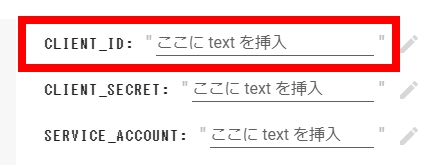

コードセルの左上の "セルを実行" ボタンをクリックしてコードを実行してください。

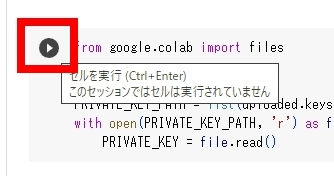

.key ファイルのアップロードは、セルを実行時に表示される [ファイル選択] ボタンでファイルを指定して行ってください。

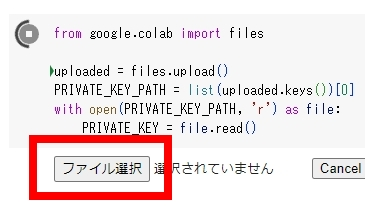

kintone アプリストアの「質問受付アプリ」と連携します。

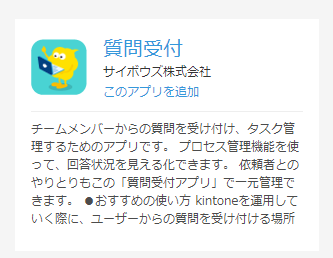

# Service Account 認証によるトークン生成

LINE WORKS Developer Console で登録したアプリの情報を基に準備します。

[Developer Console アプリ リスト](https://dev.worksmobile.com/jp/console/openapi/v2/app/list/view)

## Private Key のアップロード

Develoer Console から Private Key ダウンロードした .key ファイルをアップロードします。

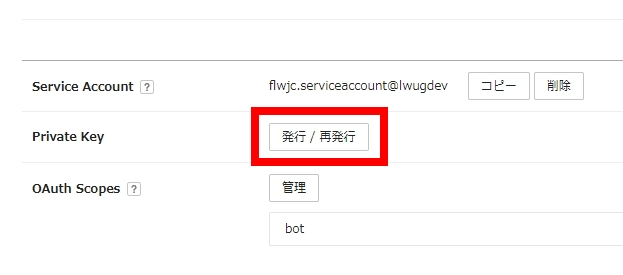

In [ ]:
from google.colab import files

uploaded = files.upload()
PRIVATE_KEY_PATH = list(uploaded.keys())[0]
with open(PRIVATE_KEY_PATH, 'r') as file:
    PRIVATE_KEY = file.read()

## Service Accout 認証の設定

LINE WORKS Developer Console のアプリの各項目の値を指定してください。

[認証の詳細はこちら](https://developers.worksmobile.com/jp/docs/auth)

下図は例で図示したところの情報を指定してください。

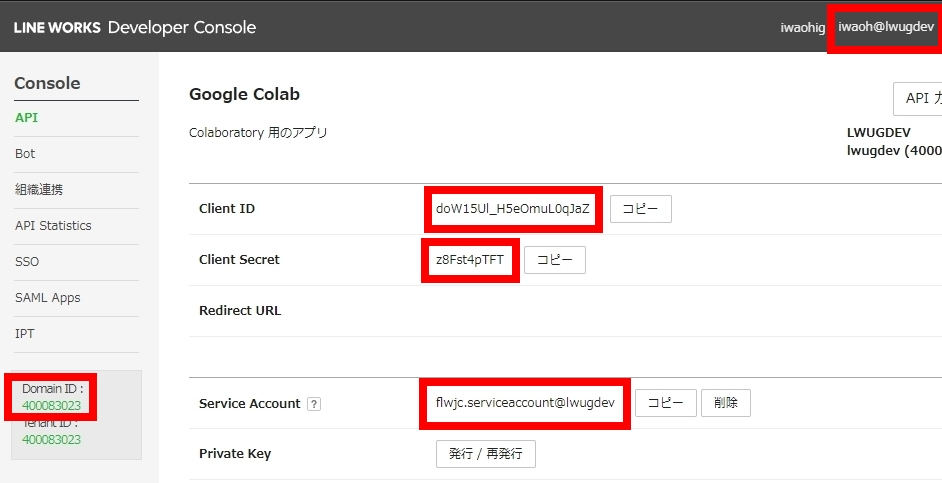

In [ ]:
CLIENT_ID = "_vLGE7KIFjLzzm_4wAef" # @param {type:"string"}
CLIENT_SECRET = "jOkpSyWnxz" # @param {type:"string"}
SERVICE_ACCOUNT = "rbi3l.serviceaccount@lwugdev" # @param {type:"string"}
USER_ID = "iwaoh@lwugdev" # @param {type:"string"}
DOMAIN_ID = "400083023" # @param {type:"string"}

## JWTの設定、生成、トークン取得

In [ ]:
import jwt
import time
import json
import requests
from datetime import datetime, timedelta

SCOPE = "bot"

# JWTのHeaderとPayloadを設定
header = {
    "alg": "RS256",
    "typ": "JWT"
}

# 現在のUTC時刻を取得して、iatとexpを設定
current_time = datetime.utcnow()
iat = int(time.mktime(current_time.timetuple()))
exp = int(time.mktime((current_time + timedelta(hours=1)).timetuple()))

payload = {
    "iss": CLIENT_ID,
    "sub": SERVICE_ACCOUNT,
    "iat": iat,
    "exp": exp
}

# JWTの生成
assertion = jwt.encode(payload, PRIVATE_KEY, algorithm="RS256", headers=header)

# POSTリクエストのためのデータを準備
data = {
    'assertion': assertion,
    'grant_type': "urn:ietf:params:oauth:grant-type:jwt-bearer",
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'scope': SCOPE
}

headers = {
    'Content-Type': 'application/x-www-form-urlencoded'
}

# API エンドポイントに POST リクエストを送信してトークンを取得
response = requests.post('https://auth.worksmobile.com/oauth2/v2.0/token', data=data, headers=headers)

# 応答の確認
if response.status_code == 200:
    token_info = response.json()
    access_token = token_info.get('access_token')
    print(f"Access Token: {access_token}")
else:
    print(f"Failed to retrieve token. Status code: {response.status_code}, Response: {response.text}")

# Bot の登録

## Bot のテナント登録とドメイン登録

In [ ]:
import requests
import json
import datetime

# 現在の時刻を取得し、文字列としてフォーマット
current_time_str = datetime.datetime.now().strftime("%Y%m%d%H%M%S")

# Botの登録情報
bot_data = {
  "botName": f"kintone Bot {current_time_str}",
  "description": "kintone 連携を試してみる Bot です",
  "administrators": [USER_ID],
  "enableCallback": True,
  "callbackEvents": ["text"],
  "callbackUrl": "https://example.com/callback",
  "photoUrl": "https://example.com/favicon.png"
}

# ヘッダー情報
headers = {
    'Authorization': f'Bearer {access_token}',
    'Content-Type': 'application/json'
}

# リクエスト
response = requests.post('https://www.worksapis.com/v1.0/bots', headers=headers, data=json.dumps(bot_data))

# レスポンスの確認
if response.status_code == 201:
    response_data = response.json()
    botId = response_data.get('botId')
    print(f"Registered Bot ID: {botId}")
else:
    print(f"Failed to register the bot. Status code: {response.status_code}, Response: {response.text}")

# Botのドメイン登録情報
request_body = {
  "visible": False
}

# APIエンドポイントの設定
endpoint = f"https://www.worksapis.com/v1.0/bots/{botId}/domains/{DOMAIN_ID}"

# ヘッダー情報
headers = {
    'Authorization': f'Bearer {access_token}',
    'Content-Type': 'application/json'
}

# リクエスト
response = requests.post(endpoint, headers=headers, data=json.dumps(request_body))

# レスポンスの確認
if response.status_code == 201:
    print(f"Successfully registered domain for Bot ID: {botId}")
else:
    print(f"Failed to register the domain. Status code: {response.status_code}, Response: {response.text}")

# kintone 質問受付アプリにレコードが登録されたら LINE WORKS の Bot からメッセージを送信

kintone の webhook でレコードを受けて LINE WORKS で送信

In [ ]:
import threading
import json
import requests
import html
from flask import Flask, request, jsonify

app = Flask(__name__)

API_URL = f'https://www.worksapis.com/v1.0/bots/{botId}/users/{USER_ID}/messages'
HEADERS = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {access_token}'
}

@app.route('/', methods=['POST'])
def kintone_webhook():
    data = request.json

    print("Received Data:", data)

    record = data.get('record', {})

    message_text = "New Record Received:\n"
    for field, field_data in record.items():
        field_type = field_data.get('type')
        value_data = field_data.get('value')

        if field_type in ['SINGLE_LINE_TEXT', 'RICH_TEXT', 'RECORD_NUMBER', 'DATE', 'STATUS', 'UPDATED_TIME', 'CREATED_TIME', '__REVISION__', '__ID__']:
            value = html.escape(str(value_data))
        elif field_type in ['CREATOR', 'MODIFIER']:
            value = html.escape(value_data.get('name', ''))
        elif field_type in ['USER_SELECT']:
            user_names = ", ".join([user['name'] for user in value_data])
            value = html.escape(user_names)
        else:
            value = "Unsupported field type"

        label = html.escape(field)
        message_text += f"{label}: {value}\n"

    message_content = {
        "content": {
            "type": "text",
            "text": message_text
        }
    }

    response = requests.post(API_URL, headers=HEADERS, data=json.dumps(message_content))
    if response.status_code == 201:
        print("Message sent successfully to LINE WORKS!")
    else:
        print(f"Failed to send message. Status code: {response.status_code}, Response: {response.text}")

    return jsonify({
        'message': 'Data received and processed'
    })

def run():
    app.run(debug=True, port=5000, use_reloader=False)

thread = threading.Thread(target=run)
thread.start()

CloudFlar で外部公開

コンソールの以下の出力に表示される URL を kintone アプリの webhook に設定してください。
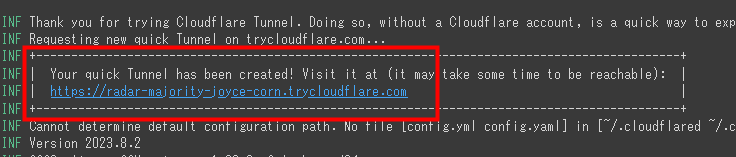

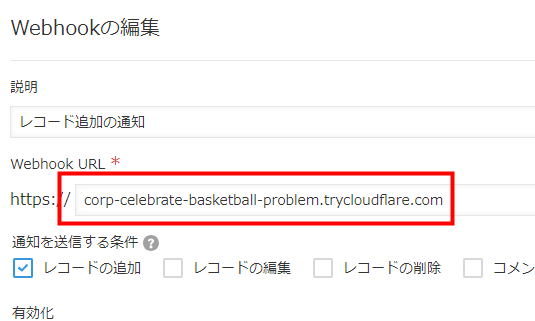

In [ ]:
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
!chmod +x cloudflared-linux-amd64
!./cloudflared-linux-amd64 tunnel --url http://127.0.0.1:5000

# Bot の削除
登録された Bot が不要な場合は、本処理で削除できます。

In [ ]:
import requests

# ヘッダーにAuthorizationを設定
headers = {
    'Authorization': f'Bearer {access_token}'
}

# Botを削除するAPIエンドポイント
url = f'https://www.worksapis.com/v1.0/bots/{botId}'

# DELETEリクエストを送信してBotを削除
response = requests.delete(url, headers=headers)

# 削除が成功した場合、HTTPステータスコード204が返されます。
if response.status_code == 204:
    print(f"Bot with ID {botId} has been deleted successfully.")
else:
    print(f"Failed to delete Bot. Status code: {response.status_code}, Response: {response.text}")
